In [1]:
import numpy as np
from util import load_hypocenters, PuuOo, load_puuoo_eqs, prune_data, GetTimeToEruption, GetTimeSinceEruption, GetEQRates
from matplotlib import pyplot as plt
import datetime
from sklearn import ensemble as ml_models

%matplotlib inline

# import data

In [2]:
def GetEastRiftZoneEQs (lat, lon):
    latpts = np.array([19.3,19.5])
    lonpts = np.array([-155.5,-155])
    A      = np.array([lonpts,[1,1]]).T
    line   = np.linalg.solve(A, latpts)
    
    croplocs = lat - line[0]*lon - line[1]
        
    inds = [j for j in range(len(lon)) if croplocs[j]<=0]
       
    return inds



In [3]:
eruption_csv_path = 'PuuOo.csv'
eq_csv_path       = 'puuoo_earthquakes.csv' 

PuuOOLoc = [-155.1050, 19.3864]

p = PuuOo(eruption_csv_path)
time0, lat0, lon0, depth0, mag0 = load_puuoo_eqs(eq_csv_path)
inds = GetEastRiftZoneEQs(lat0, lon0)
print(len(inds))

time = [time0[j] for j in range(len(inds))]
lat  = lat0[inds]
lon  = lon0[inds]
depth= depth0[inds]
mag  = mag0[inds]

tnum = np.array([t.timestamp() for t in time])
erupt = np.array([p.was_erupting(t) for t in time])

3764


In [4]:
print(lat.shape, lon.shape)

(3764,) (3764,)


In [5]:
SecsToEruption = GetTimeToEruption(time, p)
SecsSinceEruption = GetTimeSinceEruption(time, p)
EQsLastDay, EQsLastWeek, EQsLastMonth = GetEQRates(time)

## plot the data

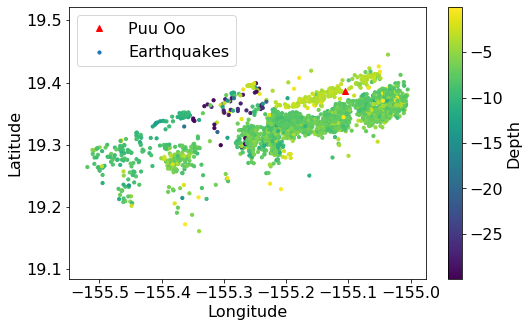

In [6]:

plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(8,5))
plt.scatter(lon, lat, 10, -depth, label='Earthquakes')
plt.plot(PuuOOLoc[0], PuuOOLoc[1], 'r^', label='Puu Oo')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Depth')
plt.axis('equal')
plt.savefig('KilaueaEQs.png')
plt.show()


## Prepare data for machine learning

In [7]:
from sklearn import preprocessing

X = np.vstack((lon, lat, depth, mag, EQsLastDay, EQsLastWeek, EQsLastMonth)).T
X = preprocessing.scale(X)
Y = np.array([1 if val==True else 0 for val in erupt])

print(sum(Y)/len(Y))
print(X.shape, Y.shape)

0.1548884165781084
(3764, 7) (3764,)


## Separate data into train and test set

In [28]:
import random

random.seed(0)
percent_train = 0.7 
percent_dev   = 0.2 # Percent test is what is left

# Get indices of eruption and non-eruption earthquakes so we can split both
eruption_idx    = [i for i, e in enumerate(erupt) if e == True]
no_eruption_idx = [i for i, e in enumerate(erupt) if e == False]
num_train_eruptions = int(percent_train * len(eruption_idx))
num_val_eruptions   = int(percent_dev * len(eruption_idx))
num_test_eruptions  = len(eruption_idx) - num_val_eruptions - num_train_eruptions
num_train_no_eruptions = int(percent_train * len(no_eruption_idx))
num_val_no_eruptions   = int(percent_dev * len(no_eruption_idx))
num_test_no_eruptions  = len(no_eruption_idx) - num_val_no_eruptions - num_train_no_eruptions
train_idx = sorted(random.sample(eruption_idx, num_train_eruptions))
remaining = sorted(list(set(eruption_idx) - set(train_idx)))
val_idx   = sorted(random.sample(remaining, num_val_eruptions))
test_idx  = sorted(list(set(remaining) - set(val_idx)))
train_idx += sorted(random.sample(no_eruption_idx, num_train_no_eruptions))
remaining  = sorted(list(set(no_eruption_idx) - set(train_idx)))
val_idx   += sorted(random.sample(remaining, num_val_no_eruptions))
test_idx  += sorted(list(set(remaining) - set(val_idx)))
assert(len(train_idx) + len(val_idx) + len(test_idx) == len(erupt))

x_train = X[train_idx,:]
x_val   = X[val_idx,:]
x_test  = X[test_idx,:]

y_train = Y[train_idx]
y_val   = Y[val_idx]
y_test  = Y[test_idx]


(2634, 7) (752, 7) (378, 7)
(2634,) (752,) (378,)


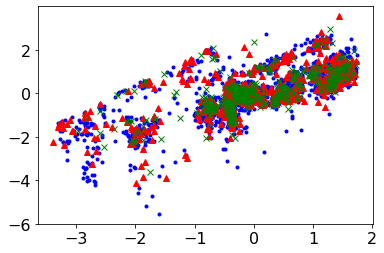

In [29]:
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

plt.figure()
plt.plot(x_train[:,0], x_train[:,1], 'b.', label='training')
plt.plot(x_val[:,0], x_val[:,1], 'r^', label='dev')
plt.plot(x_test[:,0], x_test[:,1], 'gx', label='test')


## start machine learning!

### Run a logistic regression

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lr = LogisticRegression(random_state=0,solver='lbfgs').fit(x_train, y_train)
yhat = lr.predict(x_val)

print(np.all(yhat==0))

print(metrics.confusion_matrix(y_val, yhat))
print(metrics.cohen_kappa_score(y_val, yhat))
print(metrics.roc_auc_score(y_val, yhat))

print('Naive model:')
print(metrics.confusion_matrix(y_val, np.zeros(y_val.shape)))
print(metrics.cohen_kappa_score(y_val, np.zeros(y_val.shape)))
print(metrics.roc_auc_score(y_val, np.zeros(y_val.shape)))


False
[[630   6]
 [ 82  34]]
0.38744075829383884
0.6418347430058556
Naive model:
[[636   0]
 [116   0]]
0.0
0.5


## try k means

In [31]:
from sklearn.cluster import KMeans

In [32]:
def CalcDistancesPerCluster (data):
    NumClusters = np.arange(2,50)
    distOut = np.zeros(NumClusters.shape)
    
    for nci in range(NumClusters.shape[0]):
        km = KMeans(init='k-means++', n_clusters=NumClusters[nci], n_init=10)
        km.fit(data)
        distOut[nci] = km.inertia_
        
    return NumClusters, distOut

In [43]:
def GetNearestCentroid(x, cc, label):
    cval = [np.argmin(np.linalg.norm(x[i,:]-cc, axis=1)) for i in range(x.shape[0])]
    LabelOut = label[cval]
    
    return cval, LabelOut

### calculate cluster centroids for erupting and non-erupting cases separately

In [33]:
# first find ideal number of clusters for each set

xNoErupt = x_train[y_train==0,:]
xErupt   = x_train[y_train==1,:]

NclNoErupt, distNoErupt = CalcDistancesPerCluster(xNoErupt)
NclErupt, distErupt = CalcDistancesPerCluster(xErupt)


(0, 12)

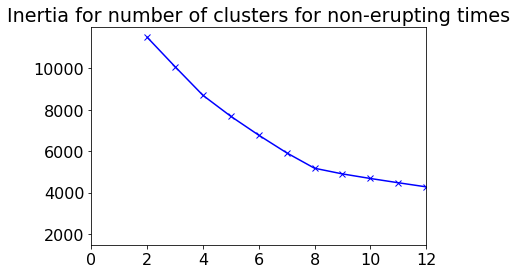

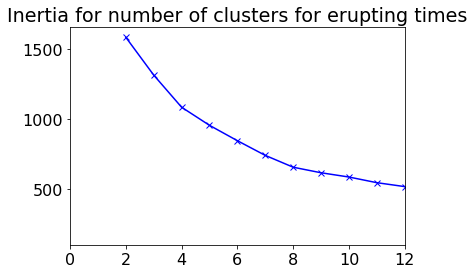

In [37]:
plt.figure()
plt.plot(NclNoErupt, distNoErupt, 'bx-')
plt.title('Inertia for number of clusters for non-erupting times')
plt.xlim(0,12)

plt.figure()
plt.plot(NclErupt, distErupt, 'bx-')
plt.title('Inertia for number of clusters for erupting times')
plt.xlim(0,12)

ideal number of clusters is around 8 for clustering based on all attributes except seconds to eruption. Now cluster each part separately

In [47]:
NclIdeal = 8

kmNoErupt = KMeans(init='k-means++', n_clusters=NclIdeal, n_init=10)
kmNoErupt.fit(xNoErupt)

kmErupt = KMeans(init='k-means++', n_clusters=NclIdeal, n_init=10)
kmErupt.fit(xErupt)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [58]:
ccAll = np.concatenate((kmNoErupt.cluster_centers_, kmErupt.cluster_centers_))
labelsErupt = np.concatenate((np.zeros(NclIdeal), np.ones(NclIdeal)))
print(labelsErupt)

cval, LabelOut = GetNearestCentroid(x_val, ccAll, labelsErupt)

print(metrics.confusion_matrix(y_val, LabelOut))
print(metrics.cohen_kappa_score(y_val, LabelOut))
print(metrics.roc_auc_score(y_val, LabelOut))



[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[[382 254]
 [ 27  89]]
0.20437362571161777
0.6839351550639774


In [43]:
Xkm = np.vstack((X.T, SecsToEruption)).T
xkmScl    = preprocessing.scale(xkm)
xkm_train = xkmScl[train_idx,:]
xkm_val   = xkmScl[val_idx,:]

### test different cluster numbers 

In [44]:
nclusters = np.arange(2,100)
distOut = np.zeros(nclusters.shape)

for nci in range(nclusters.shape[0]):
    km = KMeans(init='k-means++', n_clusters=nclusters[nci], n_init=10)
    km.fit(xkm_train)
    distOut[nci] = km.inertia_

(0, 20)

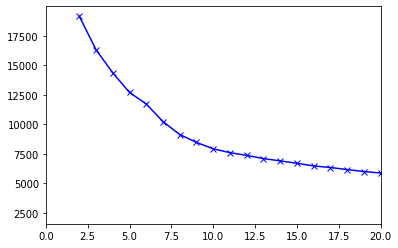

In [177]:
plt.figure()
plt.plot(nclusters, distOut, 'bx-')
plt.xlim(0,20)

In [185]:

km = KMeans(init='k-means++', n_clusters=8, n_init=10)
km.fit(xkm_train)
cnum = km.predict(xkm_train)
cc = km.cluster_centers_


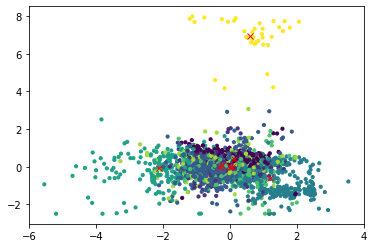

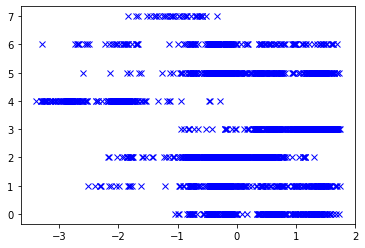

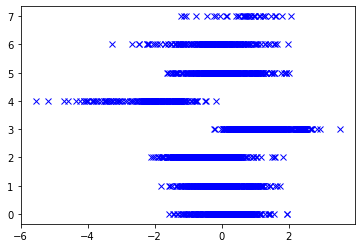

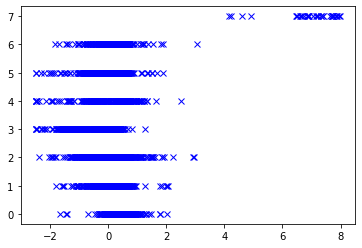

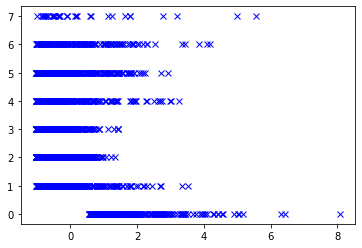

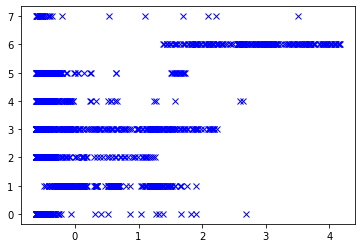

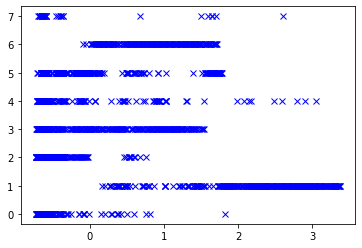

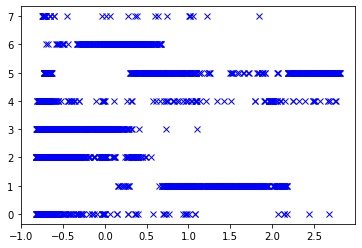

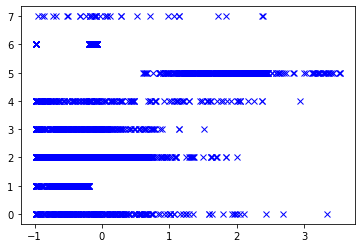

In [186]:
plt.figure
plt.scatter(xkm_train[:,1], xkm_train[:,2], 10, cnum)
plt.plot(cc[:,1], cc[:,2], 'rx')
plt.show()

for i in range(xkm_train.shape[-1]):
    plt.figure
    plt.plot(xkm_train[:,i], cnum, 'bx')
    plt.show()



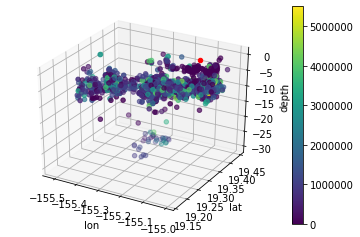

In [187]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.gca(projection='3d')
p = ax.scatter(xkm[train_idx,0], xkm[train_idx,1], -xkm[train_idx,2], c=xkm[train_idx,-1], marker='o')
ax.scatter(PuuOOLoc[0], PuuOOLoc[1], 0, c='r', marker='o')
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_zlabel('depth')
fig.colorbar(p)
plt.show()

In [188]:
def PredictTimeToErupt(xtest, cc, FeatureInds, LabelInd):
    xfeat = xtest[:,FeatureInds]
    cfeat = cc[:,FeatureInds]
    
    cval = [np.argmin(np.linalg.norm(xfeat[i,:]-cfeat, axis=1)) for i in range(xfeat.shape[0])]
    LabelOut = cc[cval, LabelInd]
    
    return cval, LabelOut
    

In [189]:
FeatureInds = np.arange(6)
LabelInd = -1

cval, yval = PredictTimeToErupt(xkm_val, cc, FeatureInds, 5)

print(yval[:10])
print(cc)

[-0.58605835 -0.12788176 -0.58605835 -0.12788176 -0.55679752 -0.58605835
 -0.58605835 -0.58605835  2.18238947 -0.58605835]
[[ 3.71953967e-01  1.22848671e-01  4.13246987e-01  1.84054970e+00
  -4.50672189e-01 -5.56797520e-01 -5.15830653e-01 -1.57917540e-01]
 [ 3.89920141e-02  1.11221024e-02  9.65486065e-03 -8.71940870e-02
   5.10594660e-01  2.18238947e+00  1.36438163e+00 -5.02914996e-01]
 [-2.15307814e-01 -2.94420309e-01  3.86049833e-03 -3.61223502e-01
  -4.70517912e-01 -5.86058349e-01 -5.87143293e-01 -2.53245585e-01]
 [ 1.07242803e+00  1.21055752e+00 -6.08460468e-01 -4.09356549e-01
   3.67916799e-02 -1.27881757e-01 -4.76168512e-01 -5.87853186e-01]
 [-2.28431432e+00 -2.10627165e+00 -8.02223988e-02  7.94816177e-02
  -3.54819963e-01 -1.93873607e-01  1.77717725e-01 -5.27425769e-02]
 [ 1.92425365e-01  6.27590239e-02 -1.74792958e-02 -1.27612784e-01
  -3.12479657e-01  1.11615909e-03  1.25694164e+00  1.89245941e+00]
 [-2.90900994e-01 -2.39197525e-01  1.16083283e-01  1.55572229e-01
   2.86903658

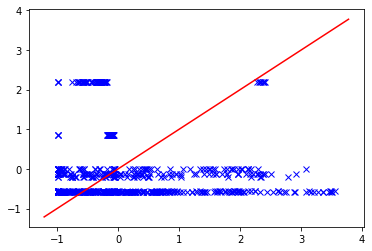

In [190]:
plt.figure()
plt.plot(xkm_val[:,-1], yval, 'bx')
plt.plot(plt.xlim(), plt.xlim(), 'r-')
plt.show()